# Bibliotecas

In [7]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from pathlib import Path
import os

warnings.filterwarnings('ignore')

# Funções (DEF)

In [8]:
# Funções auxiliares para limpeza de valores numéricos
def limpar_numero_float(valor):
    """Limpa strings numéricas com possíveis múltiplos pontos e converte para float."""
    try:
        if pd.isna(valor):
            return np.nan
        s = str(valor).strip()
        # Mantém apenas dígitos e ponto decimal
        s = ''.join(ch for ch in s if ch.isdigit() or ch == '.')
        if s == "":
            return np.nan
        # Se houver mais de um ponto, remove todos menos o último
        if s.count('.') > 1:
            partes = s.split('.')
            s = ''.join(partes[:-1]) + '.' + partes[-1]
        return float(s)
    except Exception:
        return np.nan

In [9]:
def limpar_numero_int(valor):
    """Limpa strings numéricas e converte para inteiro (quando possível)."""
    try:
        if pd.isna(valor):
            return np.nan
        s = str(valor).strip()
        s = ''.join(ch for ch in s if ch.isdigit() or ch == '.')
        if s == "":
            return np.nan
        if s.count('.') > 1:
            partes = s.split('.')
            s = ''.join(partes[:-1]) + '.' + partes[-1]
        return int(float(s))
    except Exception:
        return np.nan

In [10]:
def calcular_risco(row):
    if (
        row['nivel_de_obesidade'] in (
            'Overweight_Level_I',
            'Overweight_Level_II',
            'Obesity_Type_I',
            'Obesity_Type_II',
            'Obesity_Type_III'
        )
        and (
            row['qtd_atv_fisicas'] in ['Sedentario', 'Baixa_frequencia']
            or row['qtd_agua'] == 'Baixo_consumo'
            or row['freq_come_fora_refeicao'] == 'Always'
            or row['b_historico_familiar'] == 1
        )
    ):
        return 1  # risco de obesidade
    else:
        return 0  # sem risco imediato

In [11]:
def avaliar_modelo(nome, modelo, X_treino, y_treino, X_teste, y_teste, exibir_relatorio=True):
    # ================= Treino =================
    modelo.fit(X_treino, y_treino)

    # ================= Predições =================
    y_pred = modelo.predict(X_teste)
    y_proba = modelo.predict_proba(X_teste)[:, 1]

    # ================= Métricas =================
    acc = accuracy_score(y_teste, y_pred)
    prec = precision_score(y_teste, y_pred)
    rec = recall_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    auc = roc_auc_score(y_teste, y_proba)

    print(f"\n================= {nome} =================")
    print(f"Acurácia : {acc:.3f}")
    print(f"Precisão : {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"AUC-ROC  : {auc:.3f}")

    if exibir_relatorio:
        print("\nRelatório de Classificação:")
        print(classification_report(y_teste, y_pred, zero_division=0))

    # ================= Visualizações executivas =================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ---- Matriz de Confusão ----
    conf_disp = ConfusionMatrixDisplay.from_predictions(
        y_teste,
        y_pred,
        display_labels=['Sem risco', 'Risco'],
        normalize='true',
        ax=axes[0],
        cmap='Blues',
        values_format=".2f"
    )
    axes[0].set_title(f"Matriz de Confusão - {nome}", fontsize=12, fontweight="bold")
    axes[0].set_xlabel("Classe prevista", fontsize=10)
    axes[0].set_ylabel("Classe real", fontsize=10)

    # Deixa os rótulos mais legíveis
    axes[0].tick_params(axis='both', labelsize=9)

    # ---- Curva ROC ----
    RocCurveDisplay.from_predictions(
        y_teste,
        y_proba,
        ax=axes[1],
        name=f"Classificador (AUC = {auc:.2f})"
    )

    # Linha de referência (modelo aleatório)
    axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")

    axes[1].set_title(f"Curva ROC - {nome}", fontsize=12, fontweight="bold")
    axes[1].set_xlabel("Taxa de Falso Positivo", fontsize=10)
    axes[1].set_ylabel("Taxa de Verdadeiro Positivo", fontsize=10)
    axes[1].tick_params(axis='both', labelsize=9)
    axes[1].grid(alpha=0.2)

    # Título geral da figura
    fig.suptitle(f"Avaliação do Modelo: {nome}", fontsize=14, fontweight="bold", y=1.02)

    plt.tight_layout()
    plt.show()

    # Retorna as métricas caso queira montar uma tabela depois
    return {
        "modelo": nome,
        "acuracia": acc,
        "precisao": prec,
        "recall": rec,
        "f1": f1,
        "auc_roc": auc
    }


# Mapear/ Copiar/ Visualizar os dados

In [12]:
# Definir caminhos
url = "https://raw.githubusercontent.com/LLucasLira/Data-Analysis-and-Exploration/main/Tech%20Challenge%204%C2%AA%20Fase/Obesity.csv"
caminho_local = Path.cwd().parent / 'data' / 'raw' / 'Obesity.csv'

try:
    print(f"Tentando ler do GitHub...")
    base = pd.read_csv(url, sep=",", decimal=",", encoding="utf-8")
    print("Sucesso! Dados carregados do GitHub.")

except Exception as e:
    print(f"Erro ao acessar o GitHub: {e}")
    print(f"Tentando carregar do arquivo local: {caminho_local}")
    
    if caminho_local.exists():
        base = pd.read_csv(caminho_local, sep=",", decimal=",", encoding="utf-8")
        print("Sucesso! Dados carregados localmente.")
    else:
        print("ERRO CRÍTICO: Arquivo não encontrado nem no GitHub nem localmente.")
        raise FileNotFoundError("Verifique se o arquivo Obesity.csv está na pasta data/raw")

# Visualizar os dados
base.head()

Tentando ler do GitHub...
Erro ao acessar o GitHub: HTTP Error 429: Too Many Requests
Tentando carregar do arquivo local: c:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\06 - Fase 4 - Data Viz and Production Models\modelo_ml_para_prever_obesidade\data\raw\Obesity.csv
Sucesso! Dados carregados localmente.


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.8,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.8,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


# Validar estrutura dos dados

In [13]:
# Verificação de valores ausentes.
base.isna().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

# Padronização dos Nomes das Colunas

In [14]:
# Renomeando colunas para nomes mais descritivos em português
base = base.rename(columns={
    "Gender": "genero",
    "Age": "idade",
    "Height": "altura",
    "Weight": "peso",
    "family_history": "b_historico_familiar",
    "FAVC": "b_come_alimentos_caloricos",     	# Você come alimentos altamente calóricos com frequência?
    "FCVC": "qtd_vegetais",	                    # Você costuma comer vegetais nas suas refeições?
    "NCP": "qtd_refeicao",                      # Quantas refeições principais você faz diariamente?
    "CAEC": "freq_come_fora_refeicao",          # Você come alguma coisa entre as refeições?
    "SMOKE": "b_fuma",
    "CH2O": "qtd_agua",                         # Quanta água você bebe diariamente?     
    "SCC": "b_monitora_calorias",               # Você monitora as calorias que ingere diariamente?
    "FAF": "qtd_atv_fisicas",                   # Com que frequência você pratica atividade física?    
    "TUE": "qtd_tmp_na_internet",               # Quanto tempo você usa dispositivos tecnológicos como celular, videogame, televisão, computador e outros?
    "CALC": "freq_alcool",                      # Com que frequência você bebe álcool? 
    "MTRANS": "meio_de_transporte",
    "Obesity": "nivel_de_obesidade"
})

base = base[["idade","altura","peso","genero",              # Características;
             "qtd_refeicao","qtd_vegetais","qtd_agua","qtd_atv_fisicas","qtd_tmp_na_internet",   # Quantidade;
             "b_fuma","b_come_alimentos_caloricos","b_monitora_calorias","b_historico_familiar", # Boolean;
             "freq_come_fora_refeicao","freq_alcool",       # Hábitos;
             "meio_de_transporte","nivel_de_obesidade"]]    # Descritivo.

base.head()

,idade,altura,peso,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,nivel_de_obesidade
0,21,1.62,64,Female,3,2,2,0,1,no,no,no,yes,Sometimes,no,Public_Transportation,Normal_Weight
1,21,1.52,56,Female,3,3,3,3,0,yes,no,yes,yes,Sometimes,Sometimes,Public_Transportation,Normal_Weight
2,23,1.8,77,Male,3,2,2,2,1,no,no,no,yes,Sometimes,Frequently,Public_Transportation,Normal_Weight
3,27,1.8,87,Male,3,3,2,2,0,no,no,no,no,Sometimes,Frequently,Walking,Overweight_Level_I
4,22,1.78,89.8,Male,1,2,2,0,0,no,no,no,no,Sometimes,Sometimes,Public_Transportation,Overweight_Level_II


# Preparação e transformação dos dados

Valores binários

In [15]:
# Criando uma cópia da base original para limpeza e manipulação.
base_limpa = base

# Conversão de Gênero — Female (1) / Male (0).
base_limpa['genero'] = base['genero'].replace(['Female','Male'],[1,0])

# Conversão de Respostas Binárias — Yes (1) / No (0).
base_limpa['b_fuma'] = base['b_fuma'].replace(['yes','no'],[1,0])
base_limpa['b_monitora_calorias'] = base['b_monitora_calorias'].replace(['yes','no'],[1,0])
base_limpa['b_historico_familiar'] = base['b_historico_familiar'].replace(['yes','no'],[1,0])
base_limpa['b_come_alimentos_caloricos'] = base['b_come_alimentos_caloricos'].replace(['yes','no'],[1,0])

Tipagem

In [16]:
# Dicionário de mapeamento:
mapa_vegetais = {
    1: 'Raramente',
    2: 'As_vezes',
    3: 'Sempre'
}

# Conversão, arredondamento e substituição dos significados.
base_limpa['qtd_vegetais'] = (
    pd.to_numeric(base_limpa['qtd_vegetais'], errors='coerce')  # transforma texto em número;
    .round()                                                    # arredonda para o inteiro mais próximo;
    .astype('Int64')                                            # mantém tipo inteiro (com suporte a nulos);
    .map(mapa_vegetais)                                         # aplica o dicionário de significados.
)

In [17]:
# Dicionário de mapeamento:
mapa_refeicoes = {
    1: 'Uma_refeicao_principal_por_dia',
    2: 'Duas_refeicoes_principais_por_dia',
    3: 'Tres_refeicoes_principais_por_dia',
    4: 'Quatro_ou_mais_refeicoes_principais_por_dia'
}

# Conversão, arredondamento e substituição dos significados.
base_limpa['qtd_refeicao'] = (
    pd.to_numeric(base_limpa['qtd_refeicao'], errors='coerce')  # converte texto em número;
    .round()                                                    # arredonda o valor;
    .clip(1, 4)                                                 # garante que fique entre 1 e 4;
    .astype('Int64')                                            # converte para inteiro (suporta nulos);
    .map(mapa_refeicoes)                                        # aplica o dicionário de significados.
)

In [18]:
# Dicionário de mapeamento:
mapa_internet = {
    0: 'Uso_baixo',
    1: 'Uso_moderado',
    2: 'Uso_intenso'
}

# Conversão, arredondamento e substituição dos significados.
base_limpa['qtd_tmp_na_internet'] = (
    pd.to_numeric(base_limpa['qtd_tmp_na_internet'], errors='coerce')  # converte texto em número;
    .round()                                                          # arredonda os valores decimais;
    .clip(0, 2)                                                       # garante que fiquem entre 0 e 2;
    .astype('Int64')                                                  # converte para inteiro mantendo nulos;
    .map(mapa_internet)                                               # aplica o dicionário de significados.
)

In [19]:
mapa_agua = {
    1: 'Baixo_consumo',
    2: 'Consumo_adequado',
    3: 'Alto_consumo'
}

# Conversão, arredondamento e substituição dos significados
base_limpa['qtd_agua'] = (
    pd.to_numeric(base_limpa['qtd_agua'], errors='coerce')  # converte texto em número
    .round()                                                # arredonda valores decimais
    .clip(1, 3)                                             # garante que fiquem entre 1 e 3
    .astype('Int64')                                        # converte para inteiro mantendo nulos
    .map(mapa_agua)                                         # aplica o dicionário de significados
)

In [20]:
# Dicionário de mapeamento:
mapa_atividade = {
    0: 'Sedentario',
    1: 'Baixa_frequencia',
    2: 'Moderada_frequencia',
    3: 'Alta_frequencia'
}

# Conversão, arredondamento e substituição dos significados.
base_limpa['qtd_atv_fisicas'] = (
    pd.to_numeric(base_limpa['qtd_atv_fisicas'], errors='coerce') # converte texto em número;
    .round()                                                      # arredonda valores decimais;
    .clip(0, 3)                                                   # garante que fiquem entre 0 e 3;
    .astype('Int64')                                              # converte para inteiro mantendo nulos;
    .map(mapa_atividade)                                          # aplica o dicionário de significados.
)

In [21]:
# Aplicando as funções às colunas correspondentes
base_limpa['idade'] = base_limpa['idade'].apply(limpar_numero_int)
base_limpa['altura'] = base_limpa['altura'].apply(limpar_numero_float)
base_limpa['peso'] = base_limpa['peso'].apply(limpar_numero_float)

# Removendo linhas com valores impossíveis (idade <= 0, altura/peso não positivos)
base_limpa = base_limpa[
    (base_limpa['idade'] > 0) &
    (base_limpa['altura'] > 0) &
    (base_limpa['peso'] > 0)
]

In [22]:
base_limpa.head()

,idade,altura,peso,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,nivel_de_obesidade
0,21,1.62,64.0,1,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_moderado,0,0,0,1,Sometimes,no,Public_Transportation,Normal_Weight
1,21,1.52,56.0,1,Tres_refeicoes_principais_por_dia,Sempre,Alto_consumo,Alta_frequencia,Uso_baixo,1,0,1,1,Sometimes,Sometimes,Public_Transportation,Normal_Weight
2,23,1.80,77.0,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Moderada_frequencia,Uso_moderado,0,0,0,1,Sometimes,Frequently,Public_Transportation,Normal_Weight
3,27,1.80,87.0,0,Tres_refeicoes_principais_por_dia,Sempre,Consumo_adequado,Moderada_frequencia,Uso_baixo,0,0,0,0,Sometimes,Frequently,Walking,Overweight_Level_I
4,22,1.78,89.8,0,Uma_refeicao_principal_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_baixo,0,0,0,0,Sometimes,Sometimes,Public_Transportation,Overweight_Level_II


# Salvar base_limpa

In [23]:
# Definir o caminho base 
caminho_atual = Path.cwd() 

# Definir o caminho de destino navegando na estrutura
# .parent = sobe um nível (vai para a raiz do projeto)
# / 'data' / 'processed' = entra nas pastas destino
caminho_destino = caminho_atual.parent / 'data' / 'processed'

# Garantir que a pasta existe
# Se a pasta 'processed' não existir, o Python cria ela para evitar erro
caminho_destino.mkdir(parents=True, exist_ok=True)

# Salvar a base
nome_arquivo = 'base_limpa.csv'
caminho_completo = caminho_destino / nome_arquivo

base_limpa.to_csv(caminho_completo, index=False)

print(f"Arquivo salvo com sucesso em: {caminho_completo}")

Arquivo salvo com sucesso em: c:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\06 - Fase 4 - Data Viz and Production Models\modelo_ml_para_prever_obesidade\data\processed\base_limpa.csv


# Criação de Colunas auxiliáres

In [24]:
# Cálculo do IMC
base_limpa['imc'] = np.ceil(base_limpa['peso'] / (base_limpa['altura'] ** 2)).astype(int)

# Target: risco de obesidade

A coluna **`risco_obesidade`** será nossa variável alvo (0 = sem risco imediato, 1 = com risco aumentado de obesidade).

A regra abaixo usa:
- Hábitos de vida (atividade física, consumo de água, lanches entre refeições);
- Histórico familiar.

In [25]:
base_limpa['risco_obesidade'] = base_limpa.apply(calcular_risco, axis=1)

# Distribuição inicial da variável alvo
base_limpa['risco_obesidade'].value_counts(normalize=True) * 100


risco_obesidade
1    72.666982
0    27.333018
Name: proportion, dtype: float64

In [26]:
base_limpa.head()

,idade,altura,peso,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,nivel_de_obesidade,imc,risco_obesidade
0,21,1.62,64.0,1,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_moderado,0,0,0,1,Sometimes,no,Public_Transportation,Normal_Weight,25,0
1,21,1.52,56.0,1,Tres_refeicoes_principais_por_dia,Sempre,Alto_consumo,Alta_frequencia,Uso_baixo,1,0,1,1,Sometimes,Sometimes,Public_Transportation,Normal_Weight,25,0
2,23,1.80,77.0,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Moderada_frequencia,Uso_moderado,0,0,0,1,Sometimes,Frequently,Public_Transportation,Normal_Weight,24,0
3,27,1.80,87.0,0,Tres_refeicoes_principais_por_dia,Sempre,Consumo_adequado,Moderada_frequencia,Uso_baixo,0,0,0,0,Sometimes,Frequently,Walking,Overweight_Level_I,27,0
4,22,1.78,89.8,0,Uma_refeicao_principal_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_baixo,0,0,0,0,Sometimes,Sometimes,Public_Transportation,Overweight_Level_II,29,1


# Verificação da Distribuição da Base

In [27]:
# Exibição da distribuição percentual
print("Distribuição das genero:")
print(base_limpa['genero'].value_counts(normalize=True)*100)

Distribuição das genero:
genero
0    50.592136
1    49.407864
Name: proportion, dtype: float64


In [28]:
base_limpa.head()

,idade,altura,peso,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,nivel_de_obesidade,imc,risco_obesidade
0,21,1.62,64.0,1,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_moderado,0,0,0,1,Sometimes,no,Public_Transportation,Normal_Weight,25,0
1,21,1.52,56.0,1,Tres_refeicoes_principais_por_dia,Sempre,Alto_consumo,Alta_frequencia,Uso_baixo,1,0,1,1,Sometimes,Sometimes,Public_Transportation,Normal_Weight,25,0
2,23,1.80,77.0,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Moderada_frequencia,Uso_moderado,0,0,0,1,Sometimes,Frequently,Public_Transportation,Normal_Weight,24,0
3,27,1.80,87.0,0,Tres_refeicoes_principais_por_dia,Sempre,Consumo_adequado,Moderada_frequencia,Uso_baixo,0,0,0,0,Sometimes,Frequently,Walking,Overweight_Level_I,27,0
4,22,1.78,89.8,0,Uma_refeicao_principal_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_baixo,0,0,0,0,Sometimes,Sometimes,Public_Transportation,Overweight_Level_II,29,1


# Criação da base para o Modelo

In [29]:
# Base de modelagem
base_modelo = base_limpa.drop(['peso', 'altura', 'nivel_de_obesidade'], axis=1)

base_modelo.head()

,idade,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,imc,risco_obesidade
0,21,1,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_moderado,0,0,0,1,Sometimes,no,Public_Transportation,25,0
1,21,1,Tres_refeicoes_principais_por_dia,Sempre,Alto_consumo,Alta_frequencia,Uso_baixo,1,0,1,1,Sometimes,Sometimes,Public_Transportation,25,0
2,23,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Moderada_frequencia,Uso_moderado,0,0,0,1,Sometimes,Frequently,Public_Transportation,24,0
3,27,0,Tres_refeicoes_principais_por_dia,Sempre,Consumo_adequado,Moderada_frequencia,Uso_baixo,0,0,0,0,Sometimes,Frequently,Walking,27,0
4,22,0,Uma_refeicao_principal_por_dia,As_vezes,Consumo_adequado,Sedentario,Uso_baixo,0,0,0,0,Sometimes,Sometimes,Public_Transportation,29,1


In [30]:
base_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   idade                       2111 non-null   int64 
 1   genero                      2111 non-null   int64 
 2   qtd_refeicao                2111 non-null   object
 3   qtd_vegetais                2111 non-null   object
 4   qtd_agua                    2111 non-null   object
 5   qtd_atv_fisicas             2111 non-null   object
 6   qtd_tmp_na_internet         2111 non-null   object
 7   b_fuma                      2111 non-null   int64 
 8   b_come_alimentos_caloricos  2111 non-null   int64 
 9   b_monitora_calorias         2111 non-null   int64 
 10  b_historico_familiar        2111 non-null   int64 
 11  freq_come_fora_refeicao     2111 non-null   object
 12  freq_alcool                 2111 non-null   object
 13  meio_de_transporte          2111 non-null   obje

# Treino e teste

- **Variáveis preditoras (X)**: hábitos de vida, características demográficas e IMC;
- **Variável alvo (y)**: `risco_obesidade` (0 = sem risco, 1 = risco).

In [31]:
SEED = 1561651  # semente de aleatoriedade para reprodutibilidade

# Separando features (X) e alvo (y)
X = base_modelo.drop('risco_obesidade', axis=1)
y = base_modelo['risco_obesidade']

# Divisão treino / teste (70% / 30%), estratificando pela classe
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=SEED
)

X_treino.shape, X_teste.shape

((1477, 15), (634, 15))

In [32]:
# Distribuição da variável alvo no treino
y_treino.value_counts(normalize=True) * 100

risco_obesidade
1    72.647258
0    27.352742
Name: proportion, dtype: float64

In [33]:
# Distribuição da variável alvo no teste
y_teste.value_counts(normalize=True) * 100

risco_obesidade
1    72.712934
0    27.287066
Name: proportion, dtype: float64

In [34]:
# Visualização das primeiras linhas das features de treino
X_treino.head()

,idade,genero,qtd_refeicao,qtd_vegetais,qtd_agua,qtd_atv_fisicas,qtd_tmp_na_internet,b_fuma,b_come_alimentos_caloricos,b_monitora_calorias,b_historico_familiar,freq_come_fora_refeicao,freq_alcool,meio_de_transporte,imc
378,18,0,Tres_refeicoes_principais_por_dia,Sempre,Baixo_consumo,Moderada_frequencia,Uso_moderado,0,1,0,0,Frequently,Sometimes,Public_Transportation,24
1049,29,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Moderada_frequencia,Uso_moderado,0,1,0,1,Sometimes,Sometimes,Public_Transportation,28
1005,19,1,Tres_refeicoes_principais_por_dia,As_vezes,Alto_consumo,Sedentario,Uso_moderado,0,1,0,1,Sometimes,Sometimes,Public_Transportation,29
1081,17,0,Tres_refeicoes_principais_por_dia,As_vezes,Consumo_adequado,Baixa_frequencia,Uso_moderado,0,0,0,1,Sometimes,Sometimes,Public_Transportation,29
1891,21,1,Tres_refeicoes_principais_por_dia,Sempre,Consumo_adequado,Baixa_frequencia,Uso_moderado,0,1,0,1,Sometimes,Sometimes,Public_Transportation,46


In [35]:
X_treino.dtypes

idade                          int64
genero                         int64
qtd_refeicao                  object
qtd_vegetais                  object
qtd_agua                      object
qtd_atv_fisicas               object
qtd_tmp_na_internet           object
b_fuma                         int64
b_come_alimentos_caloricos     int64
b_monitora_calorias            int64
b_historico_familiar           int64
freq_come_fora_refeicao       object
freq_alcool                   object
meio_de_transporte            object
imc                            int64
dtype: object

## Preparação dos dados para modelagem

**pipeline de pré-processamento**

In [36]:
# Listas de colunas por tipo
numeric_features = ['idade', 'imc']
binary_features = [
    'genero',
    'b_fuma',
    'b_come_alimentos_caloricos',
    'b_monitora_calorias',
    'b_historico_familiar'
]
categorical_features = [
    'qtd_refeicao',
    'qtd_vegetais',
    'qtd_agua',
    'qtd_atv_fisicas',
    'qtd_tmp_na_internet',
    'freq_come_fora_refeicao',
    'freq_alcool',
    'meio_de_transporte'
]

# Transformações para cada grupo de variáveis
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

binary_transformer = 'passthrough'

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer combinando tudo
preprocessador = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [37]:
smote = SMOTE(random_state=SEED)

## Definição e treino dos modelos

1. **Regressão Logística**
2. **Random Forest**

In [38]:
# Pipeline com Regressão Logística
modelo_logistico = ImbPipeline(steps=[
    ('preprocess', preprocessador),
    ('smote', smote),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

# Pipeline com Random Forest
modelo_floresta = ImbPipeline(steps=[
    ('preprocess', preprocessador),
    ('smote', smote),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        class_weight='balanced',
        n_jobs=-1
    ))
])

## Vamos calcular:

- Acurácia
- Precisão
- Recall (sensibilidade)
- F1-score
- Curva-ROC


================= Regressão Logística =================
Acurácia : 0.948
Precisão : 0.976
Recall   : 0.952
F1-score : 0.964
AUC-ROC  : 0.992

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       173
           1       0.98      0.95      0.96       461

    accuracy                           0.95       634
   macro avg       0.93      0.94      0.94       634
weighted avg       0.95      0.95      0.95       634



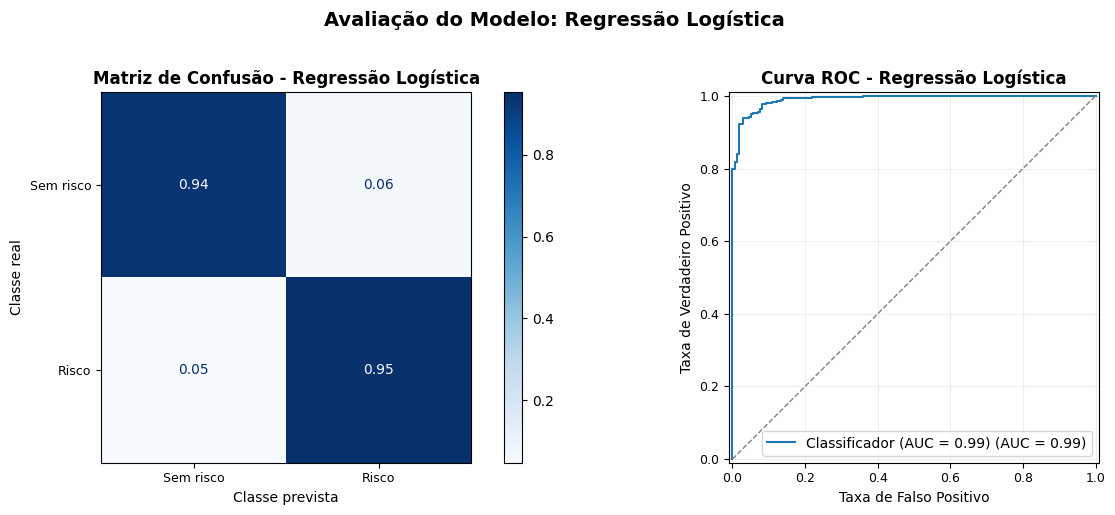


================= Random Forest =================
Acurácia : 0.992
Precisão : 0.989
Recall   : 1.000
F1-score : 0.995
AUC-ROC  : 1.000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       173
           1       0.99      1.00      0.99       461

    accuracy                           0.99       634
   macro avg       0.99      0.99      0.99       634
weighted avg       0.99      0.99      0.99       634



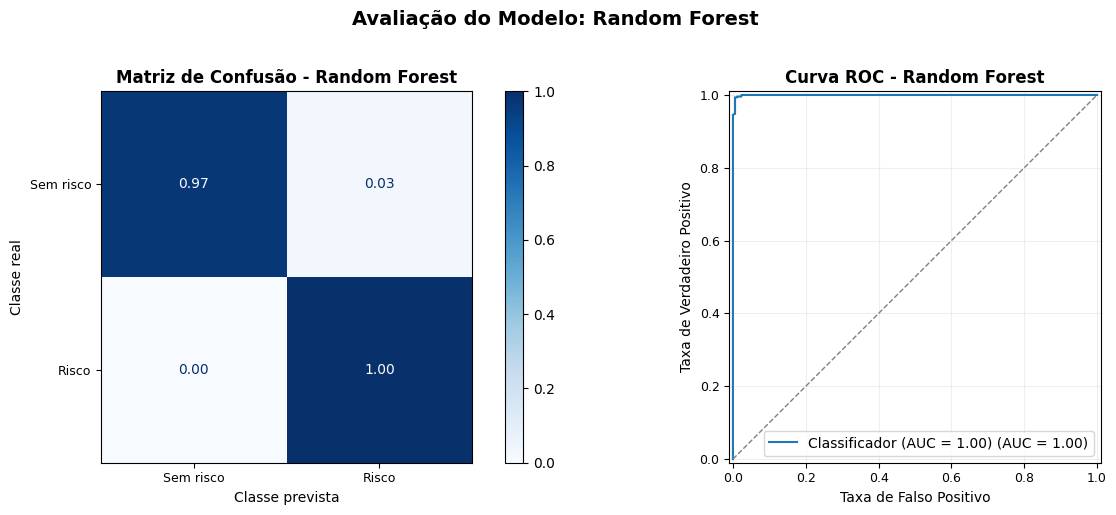

{'modelo': 'Random Forest',
 'acuracia': 0.9921135646687698,
 'precisao': 0.9892703862660944,
 'recall': 1.0,
 'f1': 0.9946062567421791,
 'auc_roc': 0.9996050305317669}

In [39]:
# Avaliando modelos
avaliar_modelo("Regressão Logística", modelo_logistico, X_treino, y_treino, X_teste, y_teste)
avaliar_modelo("Random Forest", modelo_floresta, X_treino, y_treino, X_teste, y_teste)

## Importância das variáveis

In [40]:
# Garante que o modelo Random Forest foi treinado antes de calcular importâncias
clf_rf = modelo_floresta.named_steps['clf']
ct = modelo_floresta.named_steps['preprocess']

feature_names = ct.get_feature_names_out()
importances = clf_rf.feature_importances_

importancias_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importancia': importances
    })
    .sort_values('importancia', ascending=False)
)

importancias_df.head(20)

,feature,importancia
1,num__imc,0.535691
6,bin__b_historico_familiar,0.110919
0,num__idade,0.071404
26,cat__freq_come_fora_refeicao_Sometimes,0.058150
25,cat__freq_come_fora_refeicao_Frequently,0.050421
4,bin__b_come_alimentos_caloricos,0.015021
8,cat__qtd_refeicao_Quatro_ou_mais_refeicoes_pri...,0.014797
19,cat__qtd_atv_fisicas_Moderada_frequencia,0.010652
14,cat__qtd_agua_Alto_consumo,0.009596
30,cat__freq_alcool_Sometimes,0.008789


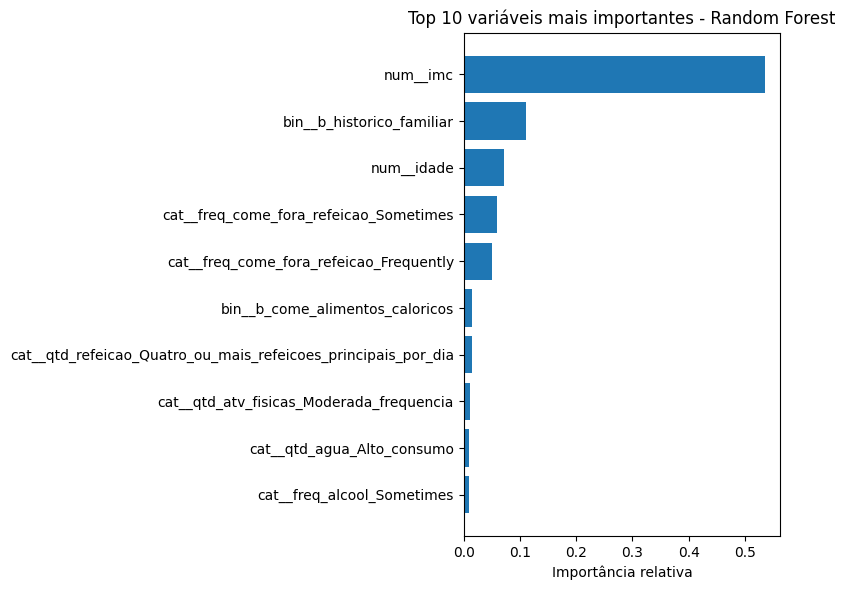

In [41]:
# Gráfico das 10 variáveis mais importantes
top_n = 10
top_features = importancias_df.head(top_n).iloc[::-1]  # inverte para plotar de baixo para cima

plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'], top_features['importancia'])
plt.xlabel('Importância relativa')
plt.title('Top 10 variáveis mais importantes - Random Forest')
plt.tight_layout()
plt.show()

## Interpretação para médicos e médicas

Alguns pontos de interpretação a partir do modelo:

- As variáveis relacionadas a **hábitos de vida** (por exemplo, frequência de atividade física,
  quantidade de refeições, consumo de água e tempo em atividades sedentárias) tendem a aparecer com
  importância elevada, indicando sua forte relação com o risco de obesidade.
- Fatores como **histórico familiar**, **consumo de alimentos calóricos** e **uso de transporte**
  mais sedentário (por exemplo, carro) também podem aumentar o risco previsto.
- A combinação de variáveis (via _one-hot encoding_) permite captar perfis de pacientes com
  padrões de risco distintos.

In [ ]:
# Salvando o melhor modelo (exemplo: Random Forest) para uso futuro

# Definir o caminho da pasta 'models' dinamicamente
caminho_models = Path.cwd().parent / 'models'

# Garantir que a pasta existe (cria se não existir)
caminho_models.mkdir(parents=True, exist_ok=True)

# Variável de controle
export_modelo = "s"

# Salvar o modelo
if export_modelo.lower() == "s":
    
    nome_arquivo = 'modelo_risco_obesidade_random_forest.joblib'
    caminho_completo = caminho_models / nome_arquivo
    joblib.dump(modelo_floresta, caminho_completo)
    print(f"Modelo salvo com sucesso em: {caminho_completo}")

else:
    print("O modelo não foi salvo (export_modelo não é 's')")